In [1]:
import math
import numpy as np
import pandas as pd
from src.knn import KNN, WeightedKNN

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
pd.options.display.max_rows = 999


reviews_sentiment = pd.read_csv('datasets/reviews_sentiment.csv', delimiter=";")

for i, row in reviews_sentiment.iterrows():
    wc = len(row['reviewText'].strip().split(' '))
    if wc != row['wordcount']:
#         print(f"El registro {i} tiene el campo wordcount incorrecto, corrigiendo...")
        reviews_sentiment.at[i,'wordcount'] = wc

# print(sentiments)

# cambiar positivo a 1, negativo a 0.
reviews_sentiment['titleSentiment'].replace('positive', 1, inplace=True)
reviews_sentiment['titleSentiment'].replace('negative', 0, inplace=True)

ones = reviews_sentiment[reviews_sentiment['titleSentiment'] == 1]['titleSentiment'].aggregate('sum')
ceroes = reviews_sentiment[reviews_sentiment['titleSentiment'] == 0]['titleSentiment'].aggregate('sum')

prop = ones/len(reviews_sentiment)
print(prop) 

reviews_sentiment['titleSentiment'].fillna(prop, inplace=True)

attributes = ['wordcount', 'titleSentiment', 'sentimentValue']
target = ['starRating']

# quitar los NaNs y verificar que no sea una porcion importante del conjunto de datos
nan_title_sentiment = reviews_sentiment[reviews_sentiment['titleSentiment'].isna()]
nan_text_sentiment = reviews_sentiment[reviews_sentiment['textSentiment'].isna()]
print(f"Cantidad de NaNs en titleSentiment {len(nan_title_sentiment)}")
print(f"Cantidad de registros {len(reviews_sentiment)}")
reviews_sentiment = reviews_sentiment.dropna()
print(f"Cantidad de registros despues de sacar NaNs: {len(reviews_sentiment)}.")

reviews_sentiment = reviews_sentiment[target + attributes]
reviews_sentiment = reviews_sentiment.sample(frac=1).reset_index(drop=True)


print(reviews_sentiment)


0.7587548638132295
Cantidad de NaNs en titleSentiment 0
Cantidad de registros 257
Cantidad de registros despues de sacar NaNs: 257.
     starRating  wordcount  titleSentiment  sentimentValue
0             5          3        1.000000        1.943862
1             5          2        1.000000        0.556533
2             3          6        1.000000        0.160616
3             4          6        1.000000        0.400986
4             5          4        1.000000        1.362262
5             5          9        1.000000        0.796459
6             2          1        0.000000        0.052841
7             1          3        1.000000       -0.256026
8             5          6        1.000000        1.080510
9             1          8        1.000000       -0.720443
10            5          2        1.000000        0.729001
11            3          5        0.000000       -0.137943
12            3          7        1.000000       -0.227463
13            1          7        1.000000

In [2]:
# Pregunta a)
print('Los comentarios valorados con 1 estrella, ¿que cantidad promedio de palabras tienen?')

mean = reviews_sentiment[reviews_sentiment['starRating'] == 1]['wordcount'].aggregate('mean')
print(f"El promedio es {round(mean, 2)}")

Los comentarios valorados con 1 estrella, ¿que cantidad promedio de palabras tienen?
El promedio es 8.16


In [3]:
from src.aux_functions import normalize_df


register_class = np.array(reviews_sentiment.starRating)
classes = np.array(reviews_sentiment.starRating.unique())

# print(sentiments.star_rating.unique())

# Se normalizan los datos por cada columna
norm_data = np.array(normalize_df(reviews_sentiment[attributes])) # me queda un arreglo de registros con 3 atributos
crossed_validation = 10
batch_size = math.floor(len(norm_data)/crossed_validation)

# valores de precision para cada corrido de validacion cruzada
knn_precisions = np.zeros(crossed_validation)
weight_knn_precisions = np.zeros(crossed_validation)


In [4]:
print(norm_data)

[[0.07142857 1.         0.76164866]
 [0.03571429 1.         0.51127554]
 [0.17857143 1.         0.43982391]
 [0.17857143 1.         0.48320381]
 [0.10714286 1.         0.65668655]
 [0.28571429 1.         0.55457533]
 [0.         0.         0.42037351]
 [0.07142857 1.         0.36463192]
 [0.17857143 1.         0.60583835]
 [0.25       1.         0.28081804]
 [0.03571429 1.         0.54240099]
 [0.14285714 0.         0.38594247]
 [0.21428571 1.         0.36978673]
 [0.21428571 1.         0.21011297]
 [0.14285714 1.         0.61160735]
 [0.32142857 0.         0.14043617]
 [0.21428571 1.         0.66802275]
 [0.03571429 1.         0.4354187 ]
 [0.         1.         0.86109546]
 [0.07142857 1.         0.08943796]
 [0.         1.         0.38559645]
 [0.03571429 1.         0.25047791]
 [0.5        0.         0.39953695]
 [0.14285714 1.         0.39132046]
 [0.14285714 1.         0.43711429]
 [0.21428571 1.         0.48609312]
 [0.         1.         0.93860629]
 [0.03571429 1.         0.64

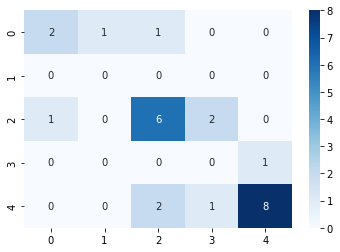

In [6]:
from src.aux_functions import confusion_matrix
from src.aux_functions import plot_matrix
from src.aux_functions import plot_precision
from seaborn import heatmap

for i in range(crossed_validation):
    # separo por lotes al conjunto de entrenamiento/testeo para la validacion cruzada
    test_batch = np.array(range(batch_size * i, batch_size * (i + 1), 1))

    # b) Dividir el conjunto de datos en un conjunto de entrenamiento y otro de prueba.
    X = np.delete(norm_data, test_batch, axis = 0)
    f_X = np.delete(register_class, test_batch, axis = 0)
    Y = norm_data[test_batch[0]:(test_batch[-1] + 1)]
    f_Y = register_class[test_batch[0]:(test_batch[-1] + 1)]

    knn = KNN(X, f_X, classes)
    weight_knn = WeightedKNN(X, f_X, classes)

    predictions = knn.batch_classify(Y)
    weight_predictions = weight_knn.batch_classify(Y)
    
    knn_confusion = confusion_matrix(predictions, f_Y, classes)
    weight_knn_confusion = confusion_matrix(weight_predictions, f_Y, classes)

    knn_precisions[i] = knn_confusion.trace()/knn_confusion.sum()
    weight_knn_precisions[i] = weight_knn_confusion.trace()/weight_knn_confusion.sum()
    plot_matrix(knn_confusion, f'crossed_validation_{crossed_validation}_{i}.png')
    if i == 2:
        heatmap(knn_confusion, annot=True, cmap='Blues', fmt='g')



In [ ]:
pip install seaborn

In [ ]:
plot_precision(knn_precisions, weight_knn_precisions, crossed_validation, filename=f'precision_{crossed_validation}.png')


In [ ]:

import numpy as np
import pandas as pd
from IPython.display import Image
from seaborn import heatmap
heatmap(knn_precisions, annot=True, cmap='Blues', fmt='g')

In [ ]:
from src.aux_functions import plot_precision_k

knn_means = []

weight_knn_means = []

# neighbours = np.arange(start=3, stop=20, step=2)
# for k in neighbours:

# iterations = np.arange(start=1, stop=15, step=1)
# for index in iterations:
#     validation_range = neighbours = np.arange(start=3, stop=20, step=1)
#     knn_precisions_avg = np.zeros(len(validation_range))
#     weight_knn_precisions_avg = np.zeros(len(validation_range))

validation_range = neighbours = np.arange(start=3, stop=25, step=1)
for crossed_validation in validation_range:        

    iterations = np.arange(start=0, stop=15, step=1)
    knn_precisions_avg = np.zeros(len(iterations))
    weight_knn_precisions_avg = np.zeros(len(iterations))
    for index in iterations:

        reviews_sentiment = reviews_sentiment.sample(frac=1).reset_index(drop=True)
        register_class = np.array(reviews_sentiment.starRating)
        classes = np.array(reviews_sentiment.starRating.unique())
        # Se normalizan los datos por cada columna
        norm_data = np.array(normalize_df(reviews_sentiment[attributes])) # me queda un arreglo de registros con 3 atributos
        batch_size = math.floor(len(norm_data)/crossed_validation)

        # valores de precision para cada corrido de validacion cruzada
        knn_precisions = np.zeros(crossed_validation)
        weight_knn_precisions = np.zeros(crossed_validation)

        for i in range(crossed_validation):
            # separo por lotes al conjunto de entrenamiento/testeo para la validacion cruzada
            test_batch = np.array(range(batch_size * i, batch_size * (i + 1), 1))

            # b) Dividir el conjunto de datos en un conjunto de entrenamiento y otro de prueba.
            X = np.delete(norm_data, test_batch, axis = 0)
            f_X = np.delete(register_class, test_batch, axis = 0)
            Y = norm_data[test_batch[0]:(test_batch[-1] + 1)]
            f_Y = register_class[test_batch[0]:(test_batch[-1] + 1)]

            knn = KNN(X, f_X, classes)
            weight_knn = WeightedKNN(X, f_X, classes)

            predictions = knn.batch_classify(Y)
            weight_predictions = weight_knn.batch_classify(Y)

            knn_confusion = confusion_matrix(predictions, f_Y, classes)
            weight_knn_confusion = confusion_matrix(weight_predictions, f_Y, classes)

            knn_precisions[i] = knn_confusion.trace()/knn_confusion.sum()
            weight_knn_precisions[i] = weight_knn_confusion.trace()/weight_knn_confusion.sum()
        #     plot_matrix(weight_knn_confusion, f'crossed_validation_{crossed_validation}_{i}.png')


        knn_precisions_avg[index] = knn_precisions.mean()
        weight_knn_precisions_avg[index] = weight_knn_precisions.mean()

#     print(knn_precisions_avg.mean())
    knn_means.append(knn_precisions_avg.mean())
    #knn_stds.append(knn_precisions_avg.std())
    weight_knn_means.append(weight_knn_precisions_avg.mean())
    #w_knn_stds.append(weight_knn_precisions_avg.std())
print('knn[6]: ' + str(knn_means[6]))
print('knn_w[6]: ' + str(weight_knn_means[6]))
plot_precision_k(knn_means, weight_knn_means, validation_range, f'crossed_validation_knn_means.png')
#     print(f'Finished neighbour {neigh_k}.')
        

In [ ]:
plot_precision_k(knn_means, weight_knn_means, validation_range, f'crossed_validation_knn_means.png')

In [ ]:
print('knn[6]: ' + str(knn_means[12]))
print('knn_w[6]: ' + str(weight_knn_means[10]))